In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras
import umap

In [2]:
DATA_PATH = 'data/'
DATASET = 'merged_data_clean.csv'

df = pd.read_csv(DATA_PATH + DATASET)
counties = df.pop('County')
df.drop(['Virginia City/County Boundaries', 'LAT', 'LON'], axis=1, inplace=True)

numeric_data = df.select_dtypes(include=[float, int])
scaled_data = StandardScaler().fit_transform(numeric_data)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(scaled_data)

umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
df = pd.concat([df, umap_df], axis=1)

c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [3]:
def map_clusters(umap_1, umap_2):
    if (umap_1 < 2) and (umap_2 < 1):
        return 0
    elif (umap_1 >= 4) and (umap_2 <= 4):
        return 1
    elif (umap_2 > 4):
        return 2
    else: return -1

c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


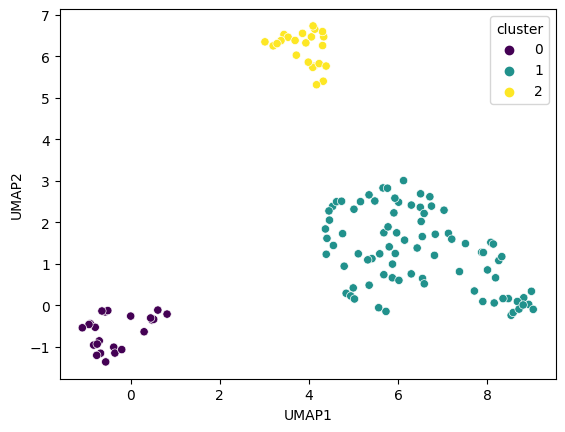

In [4]:
df['cluster'] = df.apply(lambda x: map_clusters(x['UMAP1'], x['UMAP2']), axis=1)
cluster_sizes = df.groupby('cluster').size()
df['weights'] = df['cluster'].apply(lambda x: 1 / cluster_sizes[x])

plt.figure()
sns.scatterplot(
    x="UMAP1", y="UMAP2",
    data=df, hue='cluster',
    palette='viridis', legend='brief'
)
plt.show()

In [7]:
score = df['Pounds of Food Distributed'] / df['TractLOWI']
min_score = np.min([val for val in score if val > 0.0])
imputed_score = np.array([min_score if val == 0.0 else val for val in score])
bank_score = np.log(imputed_score)

# Metric 1: Per Capita Distribution
df['PerCapitaDistribution'] = df['Pounds of Food Distributed'] / df['Pop2010']

# Metric 2: Percentage of Low-Income Population Served
df['PercentageLowIncome'] = df['TractLOWI'] / df['Pop2010']

# Metric 3: Percentage of Children Served
df['PercentageChildrenServed'] = df['Children Served via non-federal child nutrition programs'] / df['Pop2010']

metrics_to_try = [
    # (name, definition),
    ('PerCapitaDistribution', df['Pounds of Food Distributed'] / df['Pop2010']),
    ('PercentageLowIncome', df['TractLOWI'] / df['Pop2010']),
    ('PercentageChildrenServed', df['Children Served via non-federal child nutrition programs'] / df['Pop2010']),
    ('PercentageNonFederalPounds', df['Pounds of food distributed via non-federal child nutrition progr'] / df['Pop2010']),
    ('HouseHoldAndFoodPerLowPopulation', df['Households Served'] * df['Pounds of Food Distributed'] / df['Pop2010']),
    ('HouseHoldAndFoodPerLowIncome', df['Households Served'] * df['Pounds of Food Distributed'] / df['TractLOWI']),
    ('lbsFoodByLA1and10', df['Pounds of Food Distributed'] * df['LA1and10']),
    ('lbsFoodByLAPop1Share', df['Pounds of Food Distributed'] * (df['lapop1share'] * 0.01)),
    ('lbsFoodByLAKids1Share', df['Pounds of Food Distributed'] * (df['lakids1share'] * 0.01)),
    ('lbsFoodByLAPopHalfShare', df['Pounds of Food Distributed'] * (df['lapophalfshare'] * 0.01)),
    ('lbsFoodByLALowI1Share', df['Pounds of Food Distributed'] * (df['lalowi1share'] * 0.01)),
    ('lbsFoodByLAHunv1Share', df['Pounds of Food Distributed'] * (df['lahunv1share'] * 0.01)),
    ('lbsFoodByLASeniorsHalfShare', df['Pounds of Food Distributed'] * (df['laseniorshalfshare'] * 0.01)),
    ('lbsFoodByLALowIHalfShare', df['Pounds of Food Distributed'] * (df['lalowihalfshare'] * 0.01)),
    ('lbsFoodByLASNAP1Share', df['Pounds of Food Distributed'] * (df['lasnap1share'] * 0.01)),
    ('lbsFoodByPovertyRate', df['Pounds of Food Distributed'] * (df['PovertyRate'] * 0.01)),
    ('lbPerHouseServed', df['Pounds of Food Distributed'] / df['Households Served']),
    ('lbsPerIndivServed', df['Pounds of Food Distributed'] / df['Individuals Served']),
    ('PerCapitaDistributionByPovertyRate', (df['Pounds of Food Distributed'] / df['Pop2010']) * (df['PovertyRate'] * 0.01)),
    ('PerCapitaDistributionByIncome', (df['Pounds of Food Distributed'] / df['Pop2010']) * df['MedianFamilyIncome']),
    ('lbPerHouseByIncome', (df['Pounds of Food Distributed'] / df['OHU2010']) * df['MedianFamilyIncome']),
]

c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\4774-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

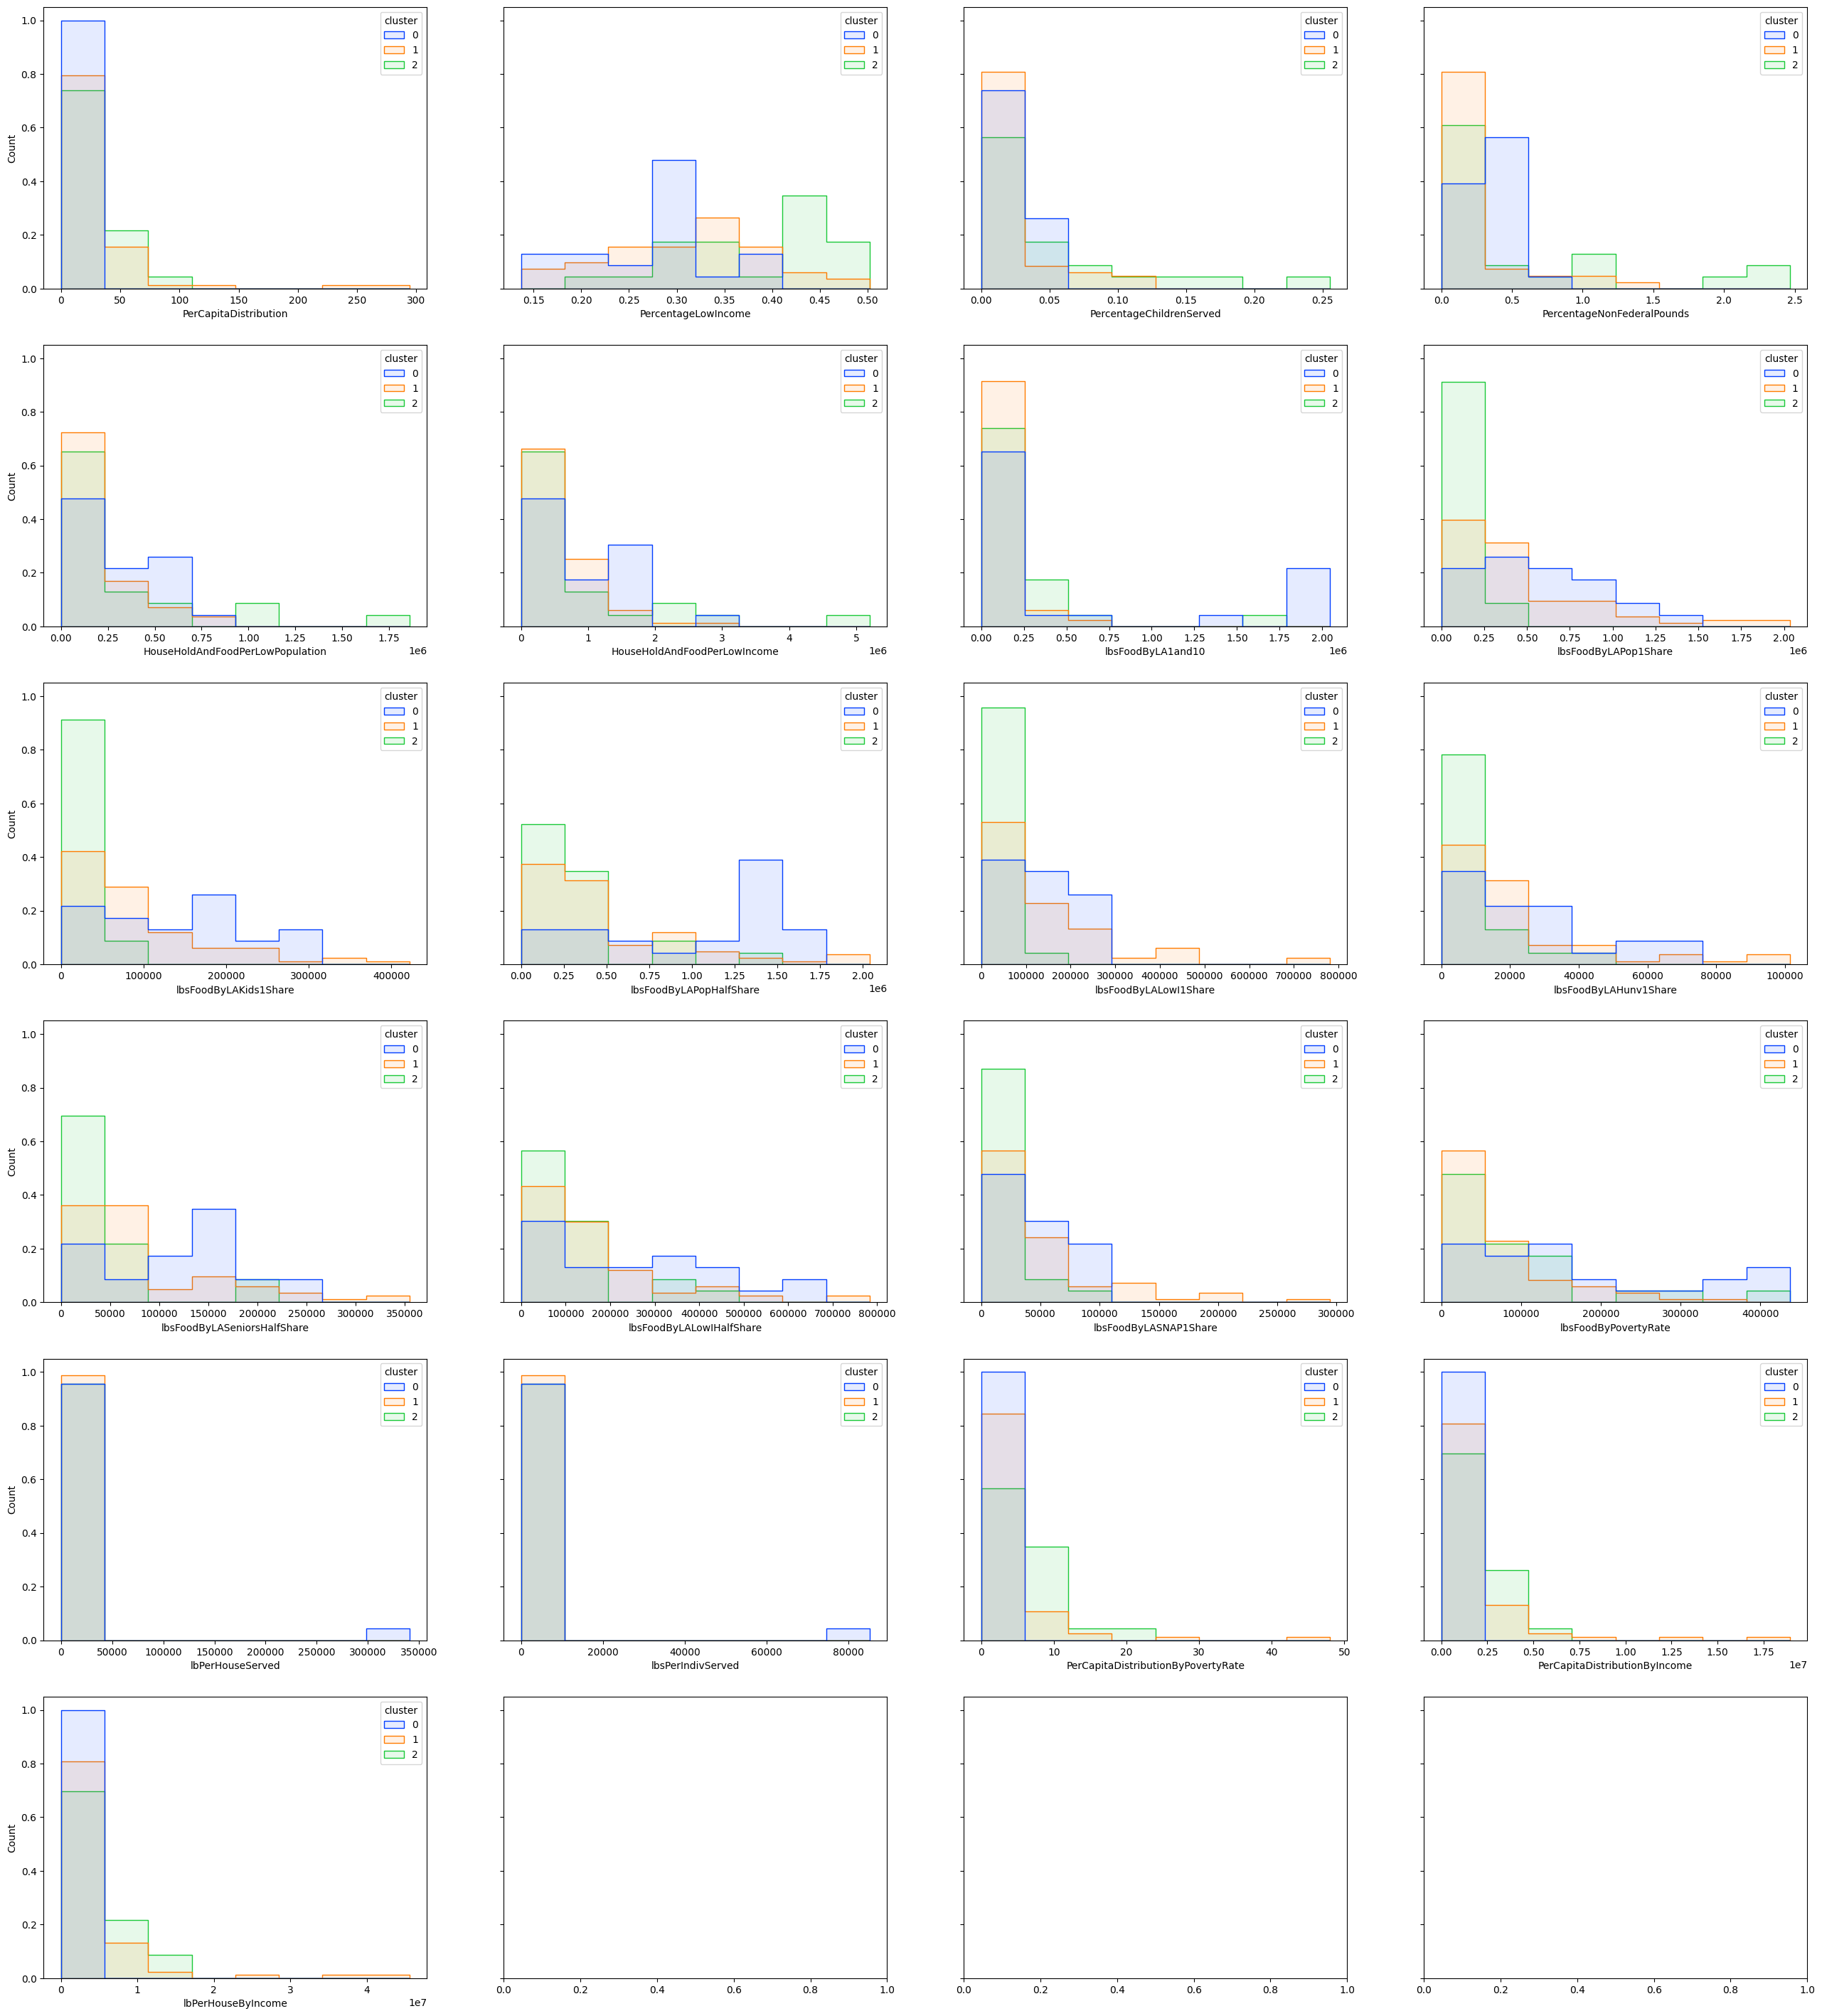

In [8]:
import math
ncols = 4
nrows = math.ceil(len(metrics_to_try) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*8, nrows*6), sharey=True)

for i, (feature, value) in enumerate(metrics_to_try):
    ax = axs[i // ncols][i % ncols]
    hist = sns.histplot(
        data=df, x=value, bins=8, hue='cluster', ax=ax,
        element='step', palette='bright', weights='weights', alpha=0.1
    )
    ax.set(xlabel=feature)
    # scatter.legend_.set_title(None)

plt.show()